In [ ]:
import numpy as np
!pip install pandas -q
import pandas as pd
import scipy.special as spsp
import matplotlib.pyplot as plt
%matplotlib inline
import sympy
import scipy.stats as spst
!pip install simpy -q
import simpy 
import copy
!pip install hyperopt -q
import hyperopt
from tqdm import tqdm

In [ ]:
BAG_CHECK_TIME = 20
BODY_CHECK_TIME = 2
WALK_TO_PLATFORM_TIME = 90
PERCENT_WITH_BAG = 0.4
TRAIN_ARRIVE_TIME = 180
TRAIN_MAX_CAPACITY = 100
num_compartments = 6

np.random.seed(10)
# Original Simulation Model
def train(env,server1,server2,queues_d0,queues_d1,Outcome,Finish):
    global compartments_d0, compartments_d1
    global next_train_event_d0, next_train_event_d1
    next_train_event_d0 = env.event()
    next_train_event_d1 = env.event()
    i = 0
    while True:
        # it needs to frequently update the resource, and clear the line, 
        # and add those who did not enter the train last time to new queue
        # we mark next_train_event as triggered such that all lines wait on these events will start 
        next_train_event_d0.succeed()
        next_train_event_d1.succeed()
        # create new next train events
        next_train_event_d0 = env.event()
        next_train_event_d1 = env.event()
        # generate random initial capacity for compartments
        compartments_d0 = [TRAIN_MAX_CAPACITY - int(np.random.normal(50,6)) - int(np.random.normal(200,30)/12) for _ in range(num_compartments)]
        compartments_d1 = [TRAIN_MAX_CAPACITY - int(np.random.normal(50,6)) - int(np.random.normal(200,30)/12) for _ in range(num_compartments)]
        # wait for the next train to arrive
        yield env.timeout(30)
        compartments_d0 = [0 for _ in range(num_compartments)]
        compartments_d1 = [0 for _ in range(num_compartments)]
        yield env.timeout(TRAIN_ARRIVE_TIME - 30)
        i+=1

# homogeneous arrival with 100 people per minute per entrance
def arrival(env,server1,server2,queues_d0,queues_d1,Outcome,Finish):
  lamba=1
  i=0
  while True:
    inter_arrival=-1/lamba*np.log(np.random.rand())
    yield env.timeout(inter_arrival)
    # Outcome.append([env.now])
    #print("Passenger", i, "arrived", env.now)
    
    # 40% of the arrival take bags with them
    u=np.random.rand()
    bag=0
    if u < PERCENT_WITH_BAG:
      bag=1
      #print("Passenger", i, "needs to go through bag check", env.now)
    Outcome.append({"arrival": env.now, "withBag": bool(bag)})
    env.process(security(i, bag,env,server1,server2,queues_d0,queues_d1,Outcome,Finish))
    i+=1

def security(i, bag,env,server1,server2,queues_d0,queues_d1,Outcome,Finish):
  rqt2=server2.request()
  # if a person has bags, they needs to go through bag scanner
  if bag==1:
    rqt1=server1.request()
    yield rqt1
    server2.release(rqt2)
    rqt2.cancel()
    # It takes a person 10 seconds for bag and body check
    yield env.timeout(BAG_CHECK_TIME)
    #print("Passenger", i, "finishes bag check", env.now)
    # Outcome[i].append(env.now)
    server1.release(rqt1)

  # It takes 2s per person for body check
  else:
    yield rqt2
    yield env.timeout(BODY_CHECK_TIME)
    server2.release(rqt2)
    #print("Passenger", i, "finishes body check", env.now)
    # Outcome[i].append(env.now)

  Outcome[i]["pass security"] = env.now
  env.process(compartment(i,env,server1,server2,queues_d0,queues_d1,Outcome,Finish))

def getEventAndCompartment(u,env,server1,server2,queues_d0,queues_d1,Outcome):
    if u < 0.5:
      return compartments_d0, next_train_event_d0
    else:
      return compartments_d1, next_train_event_d1

def compartment(i,env,server1,server2,queues_d0,queues_d1,Outcome,Finish):
    # It takes 90 seconds to walk to platform
    yield env.timeout(WALK_TO_PLATFORM_TIME)
    # outcome[i].append(env.now)
    u = np.random.rand()
    if u < 0.5:
      queues = queues_d0
    else:
      queues = queues_d1

    index = np.argmin([len(ele.queue) for ele in queues])
    shortest_queue = queues[index]

    if len(shortest_queue.queue) >= 30:
      raise RuntimeError("System failed")

    with shortest_queue.request() as request:
      yield request
      # once we have the request, i.e we are at the front of the line
      # f the compartment is not full, we enter it and leave the loop
      # if the compartment is full, we wait until next_train_event is triggered
      # and check again if the compartment is true.
      num_wait = 0
      while True:
        compartment, next_train_event = getEventAndCompartment(u,env,server1,server2,queues_d0,queues_d1,Outcome)
        if compartment[index] > 0:
          compartment[index] -= 1 
          # record departure time
          # note that i is necessary, since the first one arrives does not need to be the first one to depart
          Outcome[i]["departure"] = env.now
          Finish.append(Outcome[i])
          # outcome[i].append(num_wait)
          if num_wait > 1:
            print(f"{i}-th wait for {num_wait} trains")
          break
        else:
          # value = next_train_event
          # print("has wait")
          num_wait += 1
          yield next_train_event

def subway():
  Outcome=[]
  Finish=[]
  env=simpy.Environment()
  # bag check
  server1=simpy.Resource(env, capacity=10) 
  # body check
  server2=simpy.Resource(env, capacity=1)
  # each compartment for direction 0
  queues_d0 = [simpy.Resource(env, capacity=1) for _ in range(num_compartments)]
  queues_d1 = [simpy.Resource(env, capacity=1) for _ in range(num_compartments)]
  next_train_event_d0, next_train_event_d1 = None, None

  env.process(train(env,server1,server2,queues_d0,queues_d1, Outcome, Finish))
  env.process(arrival(env,server1,server2,queues_d0,queues_d1, Outcome, Finish))
  # Observing simluation between 17:30-18:30
  T=3600
  env.run(until=T)
  return Finish, Outcome

In [ ]:
finish_list, total_list = [], []
for i in tqdm(range(1000)):
    finish, total = subway()
    finish_list.append(finish)

    total_list.append(total)

100%|██████████| 1000/1000 [09:53<00:00,  1.68it/s]


In [ ]:
security_wait_time_with_bag = []
security_wait_time_without_bag = []
total_wait_time_with_bag = []
total_wait_time_without_bag = []
for single_run in finish_list:
  for ele in single_run:
    if ele['withBag']:
      security_wait_time_with_bag.append(ele["pass security"] - ele["arrival"])
      total_wait_time_with_bag.append(ele["departure"] - ele["arrival"])
    else:
      security_wait_time_without_bag.append(ele["pass security"] - ele["arrival"])
      total_wait_time_without_bag.append(ele["departure"] - ele["arrival"])
# security_wait_time_with_bag = [ele["pass security"] - ele["arrival"] for ele in run if ele['bag'] for run in finish_list]
# security_wait_time_without_bag = [ele["pass security"] - ele["arrival"] for ele in run if not ele['bag'] for run in finish_list]


print(f"Average waiting time for security check with bag:{np.mean(security_wait_time_with_bag)}")
print(f"Average waiting time for security check without bag:{np.mean(security_wait_time_without_bag)}")
print(f"Average total waiting time with bag:{np.mean(total_wait_time_with_bag)}")
print(f"Average total waiting time without bag:{np.mean(total_wait_time_without_bag)}")

Average waiting time for security check with bag:22.173813034168187
Average waiting time for security check without bag:287.63635629346135
Average total waiting time with bag:173.84342658336024
Average total waiting time without bag:439.4432152253376


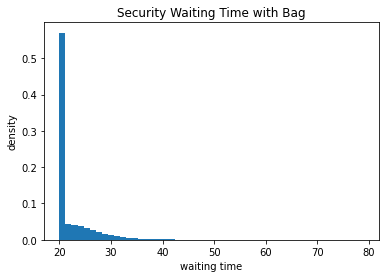

In [ ]:
plt.hist(security_wait_time_with_bag,bins=50,density=True)
# plt.xlim(0,800)
# plt.ylim(0,0.6)
plt.xlabel('waiting time')
plt.ylabel('density')
plt.title('Security Waiting Time with Bag')
plt.show()

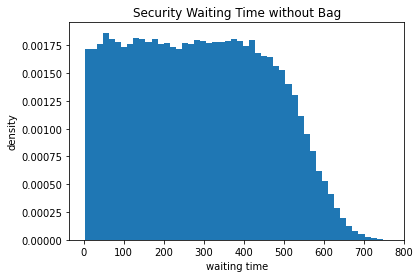

In [ ]:
plt.hist(security_wait_time_without_bag,bins=50,density=True)
# plt.xlim(0,800)
# plt.ylim(0,0.6)
plt.xlabel('waiting time')
plt.ylabel('density')
plt.title('Security Waiting Time without Bag')
plt.show()

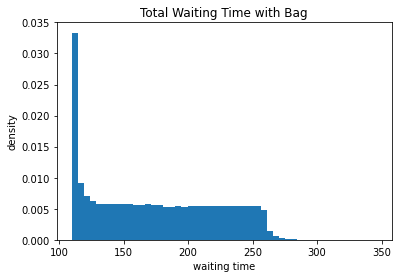

In [ ]:
plt.hist(total_wait_time_with_bag,bins=50,density=True)
# plt.xlim(0,800)
# plt.ylim(0,0.001)
plt.xlabel('waiting time')
plt.ylabel('density')
plt.title('Total Waiting Time with Bag')
plt.show()

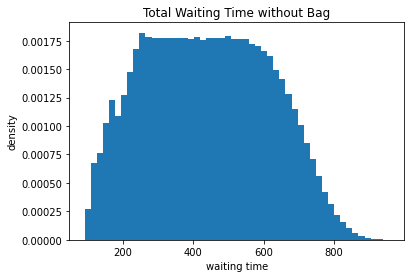

In [ ]:
plt.hist(total_wait_time_without_bag,bins=50,density=True)
# plt.xlim(0,800)
# plt.ylim(0,0.001)
plt.xlabel('waiting time')
plt.ylabel('density')
plt.title('Total Waiting Time without Bag')
plt.show()